In [53]:
%matplotlib notebook

In [54]:
# -*- coding: utf-8 -*-
# %matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
np.set_printoptions(suppress=True)

from shutil import copyfile
import random
from importlib import reload


from keras.utils import plot_model

from game import Game, GameState
from agent import Agent
from memory import Memory
from model import Residual_CNN
from funcs import playMatches, playMatchesBetweenVersions

import loggers as lg

from settings import run_folder, run_archive_folder
import initialise
import pickle
print ("Ready OK.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Ready OK.


In [55]:
env = Game()

# If loading an existing neural network, copy the config file to root
if initialise.INITIAL_RUN_NUMBER != None:
    copyfile(run_archive_folder + env.name + '/run' + str(initialise.INITIAL_RUN_NUMBER).zfill(4) + '/config.py', './config.py')

import config

######## LOAD MEMORIES IF NECESSARY ########

if initialise.INITIAL_MEMORY_VERSION == None:
    memory = Memory(config.MEMORY_SIZE)
else:
    print('LOADING MEMORY VERSION ' + str(initialise.INITIAL_MEMORY_VERSION) + '...')
    memory = pickle.load( open( run_archive_folder + env.name + '/run' + str(initialise.INITIAL_RUN_NUMBER).zfill(4) + "/memory/memory" + str(initialise.INITIAL_MEMORY_VERSION).zfill(4) + ".p",   "rb" ) )

######## LOAD MODEL IF NECESSARY ########

# create an untrained neural network objects from the config file
current_NN = Residual_CNN(config.REG_CONST, config.LEARNING_RATE, (2,) + env.grid_shape,   env.action_size, config.HIDDEN_CNN_LAYERS)
best_NN = Residual_CNN(config.REG_CONST, config.LEARNING_RATE, (2,) +  env.grid_shape,   env.action_size, config.HIDDEN_CNN_LAYERS)

#If loading an existing neural netwrok, set the weights from that model
if initialise.INITIAL_MODEL_VERSION != None:
    best_player_version  = initialise.INITIAL_MODEL_VERSION
    print('LOADING MODEL VERSION ' + str(initialise.INITIAL_MODEL_VERSION) + '...')
    m_tmp = best_NN.read(env.name, initialise.INITIAL_RUN_NUMBER, best_player_version)
    current_NN.model.set_weights(m_tmp.get_weights())
    best_NN.model.set_weights(m_tmp.get_weights())
#otherwise just ensure the weights on the two players are the same
else:
    best_player_version = 0
    best_NN.model.set_weights(current_NN.model.get_weights())

#copy the config file to the run folder
copyfile('./config.py', run_folder + 'config.py')
plot_model(current_NN.model, to_file=run_folder + 'models/model.png', show_shapes = True)

print('\n')

######## CREATE THE PLAYERS ########

current_player = Agent('current_player', env.state_size, env.action_size, config.MCTS_SIMS, config.CPUCT, current_NN)
best_player = Agent('best_player', env.state_size, env.action_size, config.MCTS_SIMS, config.CPUCT, best_NN)

LOADING MODEL VERSION 9...




In [56]:


gs = GameState(np.array([
    0,0,0,0,0,
    0,0,0,0,0,
    0,0,0,0,0,
    0,0,0,0,0,
    0,0,0,0,0,
]), 1)

preds = current_player.get_preds(gs)
headValue = preds[0]
qValue = preds[1]
moves = preds[2]
print(preds, np.argmax(preds[1]))
bestMove = moves[np.argmax(qValue)]
print ('bestMove is: ', bestMove)

(array([-0.41520002], dtype=float32), array([ 0.05439956,  0.04435591,  0.03287387,  0.03674513,  0.02975684,
        0.04134964,  0.03579015,  0.04859267,  0.03557694,  0.02906657,
        0.03348422,  0.0382243 ,  0.08384039,  0.03856984,  0.03617097,
        0.03059375,  0.04515274,  0.04630377,  0.0427826 ,  0.03405229,
        0.03678911,  0.04139983,  0.03424213,  0.03180692,  0.03807981], dtype=float32), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]) 12
bestMove is:  12


In [57]:
# 第9版本，即知道点天元了

def getBestMove(board, playerTurn):
    # playerTurn 1, X; -1, O
    gs = GameState(np.array(board), playerTurn)

    preds = current_player.get_preds(gs)
    # print (preds)
    headValue = preds[0]
    qValue = preds[1]
    moves = preds[2]
    
    bestMove = np.argmax(qValue)
    assert len(np.where (moves ==bestMove)[0] == 1)
    newBoard = np.array(board)
    newBoard[bestMove] = playerTurn
    return bestMove, newBoard

initial = [
    0,0,0,0,0,
    0,0,0,0,0,
    0,0,0,0,0,
    0,0,0,0,0,
    0,0,0,0,0,
]

assert getBestMove(initial, 1)[0] == 12
print (repr(getBestMove(initial, 1)[1]))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])


In [66]:
def getNextBoard(board, playerTurn):
    # playerTurn 1, X; -1, O
    gs = GameState(np.array(board), playerTurn)

    preds = current_player.get_preds(gs)
    # print (preds)
    headValue = preds[0]
    qValue = preds[1]
    moves = preds[2]
    
    bestMove = np.argmax(qValue)
    assert len(np.where (moves ==bestMove)[0] == 1)
    newBoard = np.array(board)
    newBoard[bestMove] = playerTurn
    return newBoard

In [85]:
nextBoard = getNextBoard(nextBoard, 1)
print (nextBoard)

[ 1  1  0  0  0  0  0  1  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  1  0  0]


In [81]:
nextBoard = [
    0,0,0,0,0,
    0,0,0,0,0,
    0,0,1,-1,0,
    0,0,0,0,0,
    0,0,0,0,0,
]
assert nextBoard == [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0]
# showBoard(getBestMove(nextBoard, 1)[1])

In [79]:
nextBoard = getBestMove(nextBoard, 1)[1]
print (nextBoard)

[ 1  1  0  0  0  0  0  1  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  1  0  0]


<IPython.core.display.Javascript object>


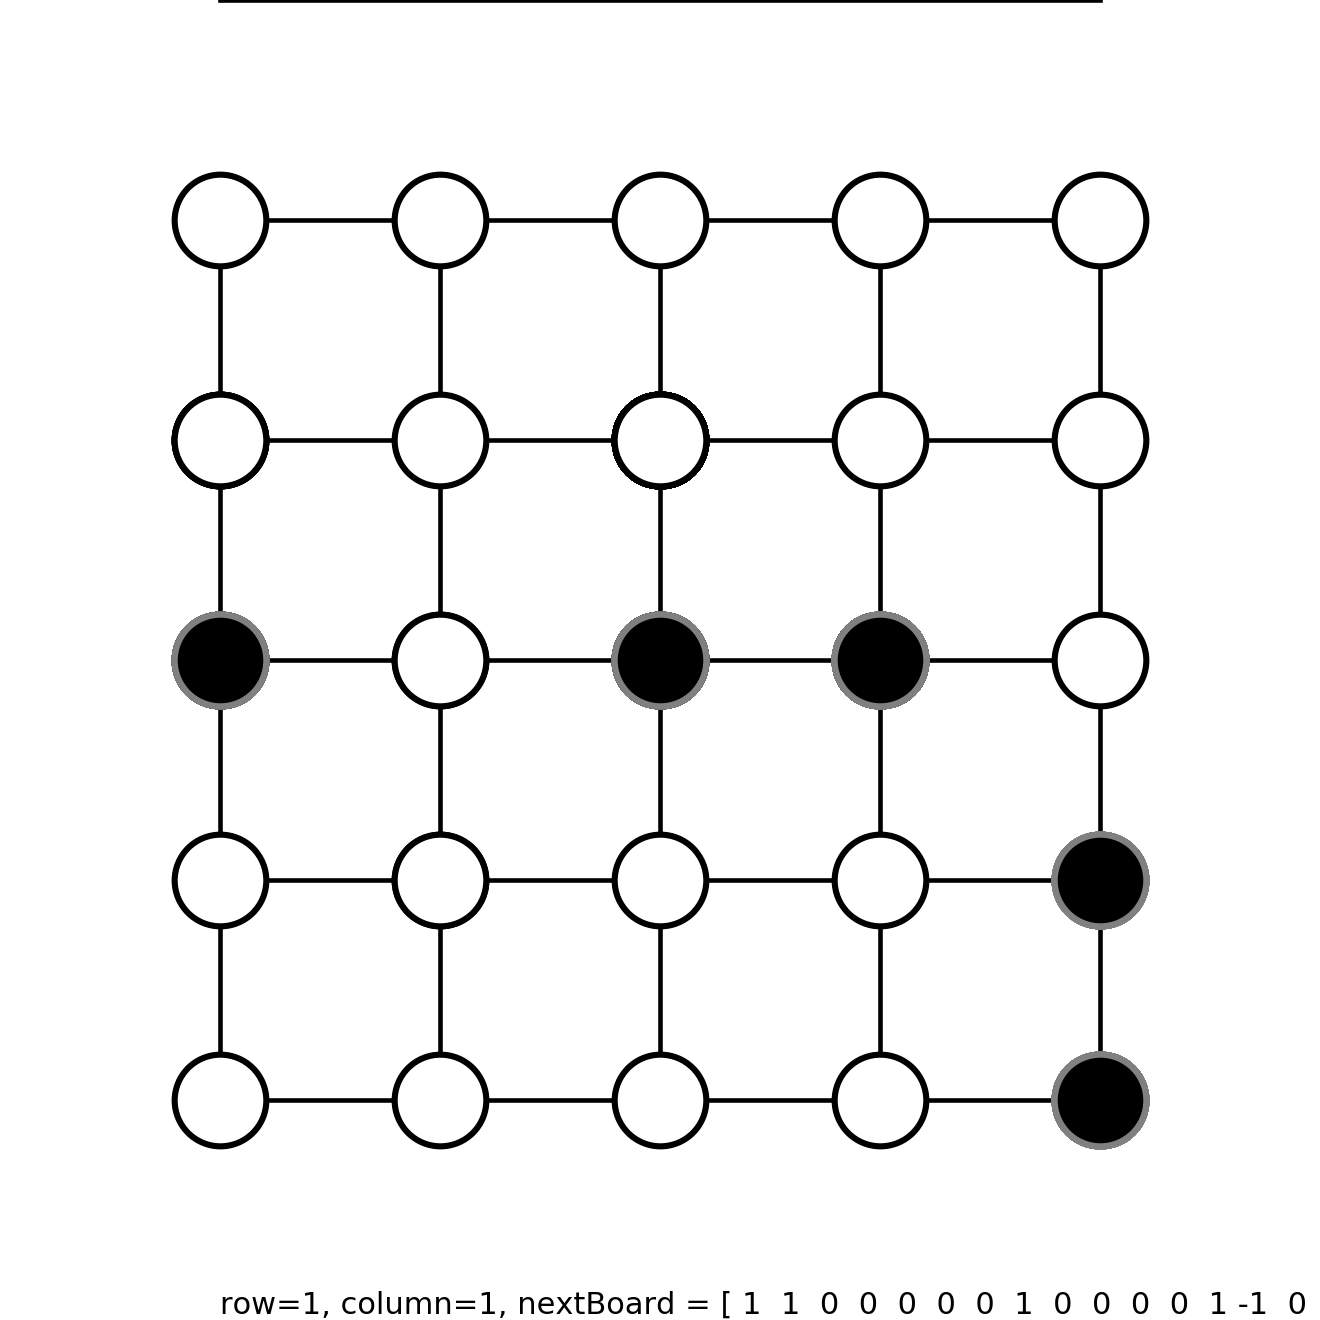

In [76]:
%matplotlib qt
import matplotlib.pyplot as plt
import numpy as np

# create a 8" x 8" board
fig = plt.figure(figsize=[6,6])
fig.patch.set_facecolor((1,1,.8))

ax = fig.add_subplot(111)

# draw the grid
for x in range(5):
    ax.plot([x, x], [0,4], 'k')
for y in range(19):
    ax.plot([0, 4], [y,y], 'k')

# scale the axis area to fill the whole figure
ax.set_position([0,0,1,1])

# get rid of axes and everything (the figure background will show through)
ax.set_axis_off()

# scale the plot area conveniently (the board is in 0,0..18,18)
ax.set_xlim(-1,5)
ax.set_ylim(-1,5)
text=ax.text(0,-1, "", va="bottom", ha="left")

def drawBoard(board):
    figBoard = np.array(board).reshape(5,5)[::-1]
    for i in range(5):
        for j in range(5):
            # print (i,j , figBoard[i][j])
            if figBoard[i][j] == -1:
                 ax.plot(i,j,'o',markersize=30, markeredgecolor=(0,0,0), markerfacecolor='w', markeredgewidth=2)
            elif figBoard[i][j] == 1:
                 ax.plot(i,j,'o',markersize=30, markeredgecolor=(.5,.5,.5), markerfacecolor='k', markeredgewidth=2)

def onclick(event):
    row = round(event.ydata)
    column = round(event.xdata)

    s1, = ax.plot(column,row,'o',markersize=30, markeredgecolor=(0,0,0), markerfacecolor='w', markeredgewidth=2)
    # s2, = ax.plot(13,16,'o',markersize=30, markeredgecolor=(.5,.5,.5), markerfacecolor='k', markeredgewidth=2)
    a= getNextBoard(nextBoard, 1)
    nextBaord = np.array(a)
    drawBoard(nextBoard)
    # tx = 'row=%d, column=%d, board = %s.' % (row, column, str(getBestMove(nextBoard, 1)[1]))
    tx = 'row=%d, column=%d, nextBoard = %s.' % (row, column, str(nextBoard))
    text.set_text(tx)
    
cid = fig.canvas.mpl_connect('button_press_event', onclick)

# drawBoard(nextBoard)
# print (nextBoard)

In [5]:
import numpy as np


a = np.array( [
    0,0,0,0,1,
    0,0,0,0,2,
    0,0,0,0,3,
    0,0,0,0,4,
    0,0,0,0,5,
])

b = a.reshape(5,5)[::-1]
print(b)


[[0 0 0 0 5]
 [0 0 0 0 4]
 [0 0 0 0 3]
 [0 0 0 0 2]
 [0 0 0 0 1]]


<IPython.core.display.Javascript object>


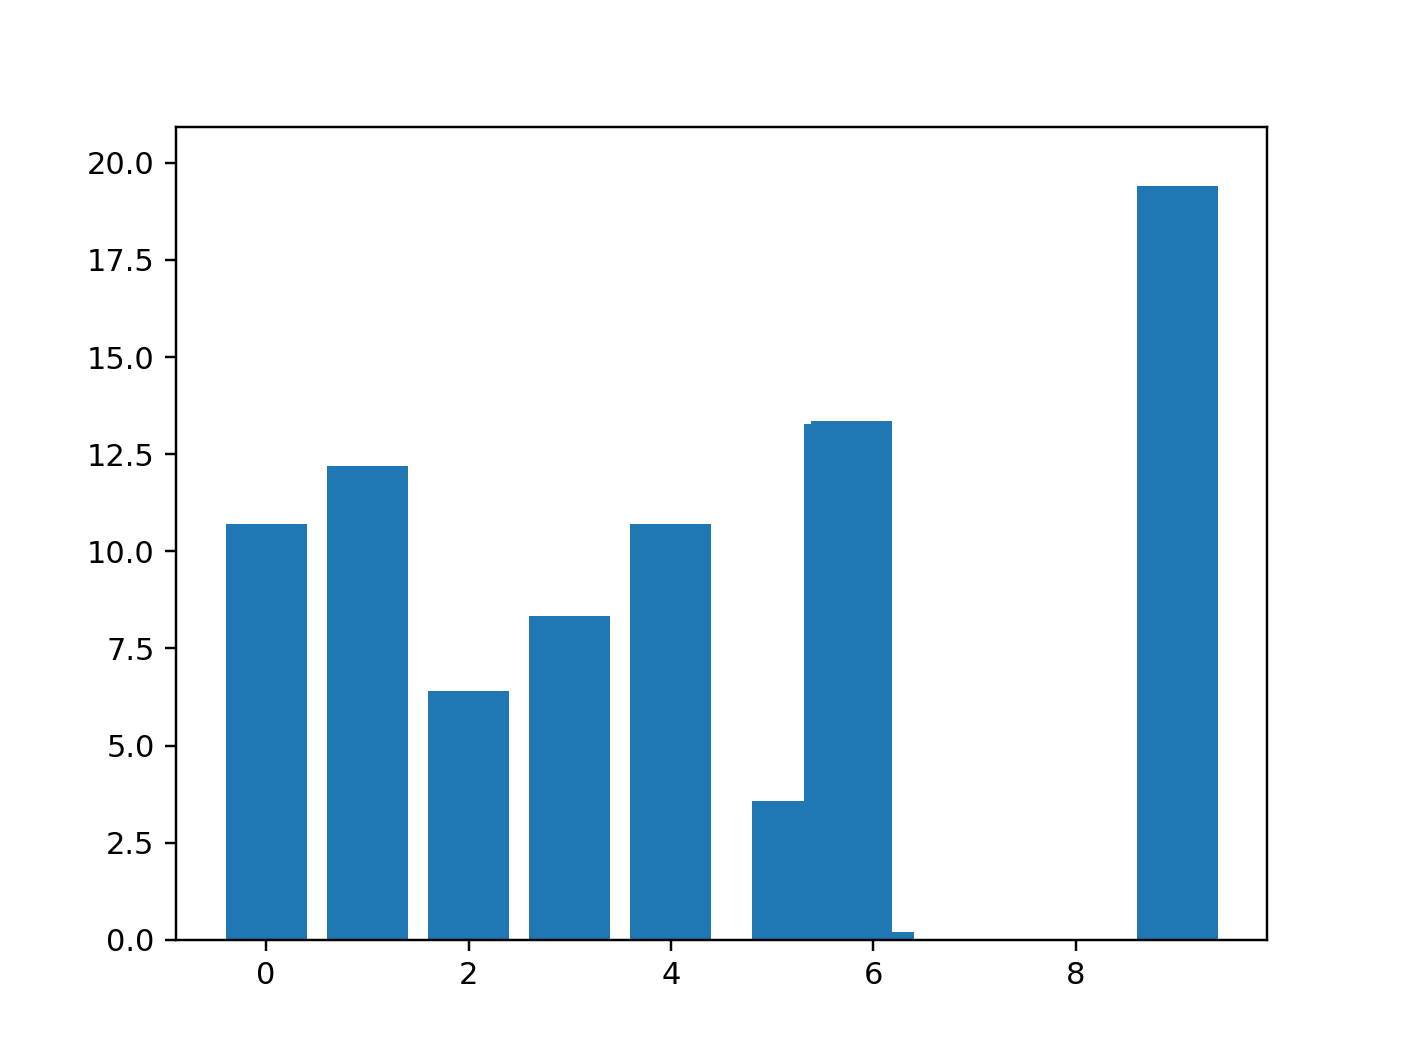

In [86]:
# move histo with mouse
# https://matplotlib.org/users/event_handling.html


import numpy as np
import matplotlib.pyplot as plt

class DraggableRectangle:
    def __init__(self, rect):
        self.rect = rect
        self.press = None

    def connect(self):
        'connect to all the events we need'
        self.cidpress = self.rect.figure.canvas.mpl_connect(
            'button_press_event', self.on_press)
        self.cidrelease = self.rect.figure.canvas.mpl_connect(
            'button_release_event', self.on_release)
        self.cidmotion = self.rect.figure.canvas.mpl_connect(
            'motion_notify_event', self.on_motion)

    def on_press(self, event):
        'on button press we will see if the mouse is over us and store some data'
        if event.inaxes != self.rect.axes: return

        contains, attrd = self.rect.contains(event)
        if not contains: return
        print('event contains', self.rect.xy)
        x0, y0 = self.rect.xy
        self.press = x0, y0, event.xdata, event.ydata

    def on_motion(self, event):
        'on motion we will move the rect if the mouse is over us'
        if self.press is None: return
        if event.inaxes != self.rect.axes: return
        x0, y0, xpress, ypress = self.press
        dx = event.xdata - xpress
        dy = event.ydata - ypress
        #print('x0=%f, xpress=%f, event.xdata=%f, dx=%f, x0+dx=%f' %
        #      (x0, xpress, event.xdata, dx, x0+dx))
        self.rect.set_x(x0+dx)
        self.rect.set_y(y0+dy)

        self.rect.figure.canvas.draw()


    def on_release(self, event):
        'on release we reset the press data'
        self.press = None
        self.rect.figure.canvas.draw()

    def disconnect(self):
        'disconnect all the stored connection ids'
        self.rect.figure.canvas.mpl_disconnect(self.cidpress)
        self.rect.figure.canvas.mpl_disconnect(self.cidrelease)
        self.rect.figure.canvas.mpl_disconnect(self.cidmotion)

fig = plt.figure()
ax = fig.add_subplot(111)
rects = ax.bar(range(10), 20*np.random.rand(10))
drs = []
for rect in rects:
    dr = DraggableRectangle(rect)
    dr.connect()
    drs.append(dr)

plt.show()

In [ ]:
# store objects? http://holoviews.org/user_guide/Plots_and_Renderers.html
